In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
import yaml
import roboticstoolbox as rtb

import matplotlib.pyplot as plt
from ipywidgets import interact, widgets


from assistive_arm.utils.data_preprocessing import prepare_opencap_markers

## Read data

### Marker data

In [3]:
subject = "subject_1"
subject_data = Path("/Users/xabieririzar/Desktop/Life/Studium/TUM/M.Sc Robotics/Masterarbeit Harvard/Thesis/Subject testing/Subject data/") / subject
trial = subject_data / "trial_2"

project_moco_data = Path("/Users/xabieririzar/uni-projects/Harvard/assistive-arm/moco/")
control_solutions = project_moco_data / "control_solutions"

# Set directories
opencap_markers = pd.read_csv(trial / "opencap_tracker.trc", delimiter="\t", skiprows=3).tail(-1)
filtered_markers = prepare_opencap_markers(opencap_markers)

# Read solution and yaml config
solution_path = control_solutions / "opencap_simple_assistance_false_2023-09-22_17-13.sto"
control_solution = pd.read_csv(solution_path, delimiter="\t", skiprows=18)
config_path = control_solutions / f"{solution_path.stem}.yaml"

try:
    with open(config_path, "r") as f:
        config_file = yaml.load(f, Loader=yaml.FullLoader)
except FileNotFoundError:
    print(f"No config file found at {config_path}")


No config file found at /Users/xabieririzar/uni-projects/Harvard/assistive-arm/moco/control_solutions/opencap_simple_assistance_false_2023-09-22_17-13.yaml


### Get pelvis marker and set it as human anchoring position

In [5]:
pelvis_x = (filtered_markers["r.PSIS_study"].X + filtered_markers["L.PSIS_study"].X)/2 
pelvis_y = (filtered_markers["r.PSIS_study"].Y + filtered_markers["L.PSIS_study"].Y)/2 
pelvis_z = (filtered_markers["r.PSIS_study"].Z + filtered_markers["L.PSIS_study"].Z)/2 

pelvis_marker = pd.DataFrame({"Time": filtered_markers.Time.t, "X": pelvis_x, "Y": pelvis_y, "Z": pelvis_z})
pelvis_marker = pelvis_marker[(pelvis_marker.Time >= 1.8) & (pelvis_marker.Time <= 3.2)].reset_index(drop=True)
pelvis_marker.set_index("Time", inplace=True)
new_index = pd.Index(np.arange(pelvis_marker.index.min(), pelvis_marker.index.max() + 0.025, step=0.025), name="Time")
pelvis_marker_aligned = pelvis_marker.reindex(new_index, method="nearest")
pelvis_marker_aligned = pelvis_marker_aligned.iloc[:-8]

### Read assistive force profile

In [7]:
assistive_force = control_solution[["time", "/forceset/reserve_jointset_ground_pelvis_pelvis_tx", "/forceset/reserve_jointset_ground_pelvis_pelvis_ty"]]
assistive_force.set_index("time", inplace=True)
assistive_force.columns = ["X", "Y"]
assistive_force.insert(2, "Z", 0)
assistive_force *= 100

## Calculate optimal link length ratio

### Get distance vector from pelvis to anchor point

In [8]:
chair_position = np.array([-0.5, 0.5, -0.075])
pelvis_to_chair = chair_position - pelvis_marker_aligned

### Calculate optimal length

In [9]:
def get_rotation_matrix(degrees: float) -> np.array:
    return np.array([
            [np.cos(np.deg2rad(degrees)), -np.sin(np.deg2rad(degrees)), 0],
            [np.sin(np.deg2rad(degrees)), np.cos(np.deg2rad(degrees)), 0],
            [0, 0, 1]
        ])

def compute_torque_profiles(l1: float, l2: float, F: pd.DataFrame, position: pd.DataFrame, elbow_up: bool=True) -> np.array:
    """ Compute the torque at the shoulder joint given the position of the end effector and the force applied to it.

    Args:
        l1 (float): length of the first link
        l2 (float): length of the second link
        position (N, 3): dataframe with the position of the end effector over time
        elbow_up (int, optional): 1 if the elbow is up, -1 if the elbow is down. Defaults to 1.

    Returns:
        np.array: torque array
    """
    N = position.shape[0]

    # Rotate EE position to robot frame
    rotate_ee = get_rotation_matrix(-90)
    pos_rot = (rotate_ee @ position.T).T # We apply the transpose to get the correct shape
    pos_rot.columns = ["X", "Y", "Z"]

    arccos_argument = (pos_rot.X**2 + pos_rot.Y**2 - l1**2 - l2**2) / (2 * l1 * l2)
    if np.any(arccos_argument > 1) or np.any(arccos_argument < -1):
        return np.nan, np.nan, np.nan

    theta_2 = np.arccos(arccos_argument) * (1 if elbow_up else -1)
    theta_1 = np.arctan2(pos_rot.Y, pos_rot.X) - np.arctan2(l2 * np.sin(theta_2), l1 + l2*np.cos(theta_2))

    P_EE = np.array([
        l1*np.cos(theta_1) + l2*np.cos(theta_1 + theta_2),
        l1*np.sin(theta_1) + l2*np.sin(theta_1 + theta_2),
        np.zeros(theta_1.shape)])
    
    diff = np.linalg.norm(P_EE - pos_rot.T)

    jacobian = np.array([
        [-l1*np.sin(theta_1)-l2*np.sin(theta_1+theta_2), -l2*np.sin(theta_1+theta_2)],
        [l1*np.cos(theta_1)+l2*np.cos(theta_1+theta_2), l2*np.cos(theta_1+theta_2)],
        np.ones((2, N))
    ])
    jacobian = np.transpose(jacobian, (2, 0, 1)) # Bring jacobian to correct shape

    # Force vector in robot frame, negate because we want to push
    rotate_forces = get_rotation_matrix(90)
    F_rot = -(rotate_forces @ F.T).T.to_numpy()
    F_rot = F_rot[:, :-1] # remove Z component
    
    # Build force and torque vector (N, 3, 1))
    torque = np.cross(pos_rot, F_rot)[:, -1].reshape(N, 1)
    F_tot = np.concatenate((F_rot, torque), axis=1).reshape(N, 3, 1)

    torque = jacobian.transpose((0, 2, 1)) @ F_tot
    joint_angles = np.concatenate((theta_1, theta_2), axis=0).reshape(N, 2)

    return torque.squeeze(), joint_angles, jacobian

In [10]:
min_necessary_length = np.linalg.norm(pelvis_to_chair, axis=1).max() + 0.05 # 5 cm safety margin
print("Minimum stretched length: ", min_necessary_length)

resolution = 50
link_lengths_1 = np.linspace(0.1, 1, resolution)
link_lengths_2 = np.linspace(0.1, 1, resolution)

results = []

for l1 in link_lengths_1:
    for l2 in link_lengths_2:
        if l1 + l2 < min_necessary_length:
            continue
        torques, joint_angles, jacobian = compute_torque_profiles(l1, l2, F=assistive_force, position=pelvis_to_chair, elbow_up=1)

        if np.any(np.isnan(torques)) or np.any(np.isnan(joint_angles)):
            continue
        
        det_jacobian = np.linalg.det(jacobian @ jacobian.transpose(0, 2, 1))
        
        result = {
            'l1': l1,
            'l2': l2,
            'tau_1': torques[:, 0],
            'tau_2': torques[:, 1],
            'theta_1': joint_angles[:, 0],
            'theta_2': joint_angles[:, 1],
            'jacobian': jacobian
        }
        results.append(result)

Minimum stretched length:  0.8125806578745655


In [11]:
link_length_torque_profiles = pd.DataFrame(results)
link_length_torque_profiles.dropna(inplace=True)

In [12]:
peak_torques = link_length_torque_profiles[["tau_1", "tau_2"]].map(lambda x: np.abs(x).max())
min_overall_torque = np.linalg.norm(peak_torques, axis=1)
min_torque_loc = min_overall_torque.argmin()
ideal_torque = peak_torques.iloc[min_torque_loc]

/var/folders/l7/_v10skvn04v2ky4vndzrcrlr0000gn/T/ipykernel_7656/134686936.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.scatter(ideal_torque[0], ideal_torque[1], c="r")


Text(0, 0.5, 'Peak tau_2')

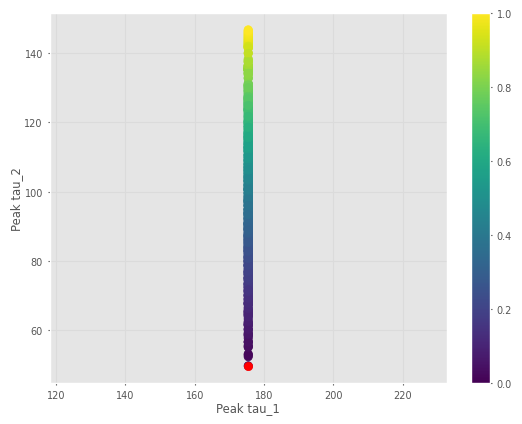

In [13]:
plt.title("")
plt.scatter(peak_torques.tau_1, peak_torques.tau_2, c=min_overall_torque, cmap="viridis")
plt.scatter(ideal_torque[0], ideal_torque[1], c="r")
plt.colorbar()
plt.axis("equal")
plt.xlabel("Peak tau_1")
plt.ylabel("Peak tau_2")

In [14]:
l1, l2, tau_1, tau_2, theta_1, theta_2, jacobian = link_length_torque_profiles.iloc[min_torque_loc]

In [15]:
# Rotate back to world frame
l1 = 0.6
l2 = 0.6

rotate_minus_90 = get_rotation_matrix(-90)
pos_rot = (rotate_minus_90 @ pelvis_to_chair.T).T
pos_rot.columns = ["X", "Y", "Z"]

arccos_argument = (pos_rot.X**2 + pos_rot.Y**2 - l1**2 - l2**2) / (2 * l1 * l2)
if not (np.any(arccos_argument > 1) or np.any(arccos_argument < -1)):
    theta_2_inv = np.arccos(arccos_argument)
    theta_1_inv = np.arctan2(pos_rot.Y, pos_rot.X) - np.arctan2(l2 * np.sin(theta_2), l1 + l2*np.cos(theta_2))

P_EE = np.array([l1*np.cos(theta_1_inv) + l2*np.cos(theta_1_inv + theta_2_inv), l1*np.sin(theta_1_inv) + l2*np.sin(theta_1_inv + theta_2_inv), np.zeros(theta_1_inv.shape)])
P_L1 = np.array([l1*np.cos(theta_1_inv), l1*np.sin(theta_1_inv), np.ones(theta_1_inv.shape)])

np.linalg.norm(P_EE - pos_rot.T)

1.0065554202506664

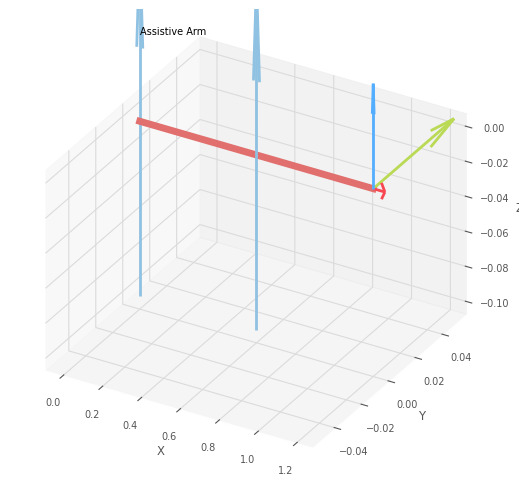

PyPlot3D backend, t = 0.05, scene:
  robot: Text(0.0, 0.0, 'Assistive Arm')

<Figure size 640x480 with 0 Axes>

In [19]:
robot = rtb.DHRobot(
    [
        rtb.RevoluteDH(d=0, a=l1),
        rtb.RevoluteDH(d=0, a=l2)
    ], name="Assistive Arm"
)
angles = []
for i in range(len(pos_rot)):
    angles.append(robot.ik_LM(pos_rot.iloc[i])[0])
angles = np.array(angles)
robot.plot(q=[0,0])

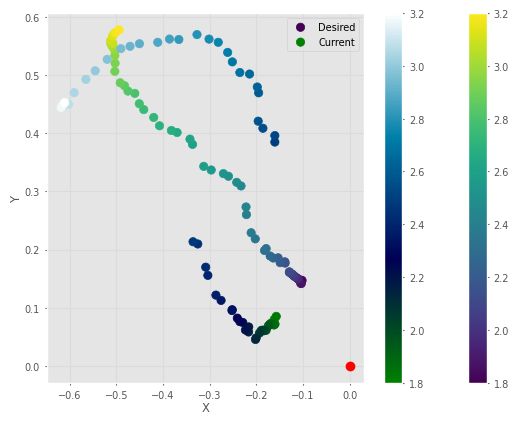

In [18]:
plt.scatter(pos_rot.X, pos_rot.Y, c=pos_rot.index, cmap="viridis", label="Desired")
plt.colorbar()
plt.scatter(P_EE[0], P_EE[1], c=pos_rot.index, cmap="ocean", label="Current")
plt.colorbar()
plt.plot(0, 0, "o", c="r")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.show()

In [30]:
theta_1_inv = angles[:, 0]
theta_2_inv = angles[:, 1]

P_EE = np.array([l1*np.cos(theta_1_inv) + l2*np.cos(theta_1_inv + theta_2_inv), l1*np.sin(theta_1_inv) + l2*np.sin(theta_1_inv + theta_2_inv), np.zeros(theta_1_inv.shape)])
P_L1 = np.array([l1*np.cos(theta_1_inv), l1*np.sin(theta_1_inv), np.ones(theta_1_inv.shape)])

In [31]:
def plot_func(timestep):
    plt.figure(figsize=(5, 5))
    ax = plt.axes(projection="3d")
    ax.view_init(elev=90, azim=-90)
    rotate_90 = get_rotation_matrix(90)

    pelvis_pos = pelvis_marker_aligned.iloc[timestep]
    l1_vector = rotate_90 @ P_L1[:, timestep]
    l2_vector = rotate_90 @ P_EE[:, timestep]
    l2_base = pelvis_pos + l1_vector
    vector = pelvis_to_chair.iloc[timestep].T

    ax.scatter(*pelvis_pos, color="b")
    ax.text(*pelvis_pos, "Pelvis marker", color="b")

    ax.scatter(*chair_position, color="r")
    ax.text(*chair_position, "Chair position", color="r")

    origin = [0, 0, 0]
    ax.scatter(*origin)

    ax.quiver(*pelvis_pos, *vector, color="g")
    ax.quiver(*pelvis_pos, *l1_vector, color="g")
    ax.quiver(*l2_base, *l2_vector, color="r")

    ax.set_xlim([-0.65, pelvis_marker_aligned.X.max()])
    ax.set_ylim([0.5, 1.1])

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Pelvis marker and Vector at time {}'.format(timestep))

    plt.show()

In [32]:
%matplotlib widget
interact(plot_func, timestep=widgets.IntSlider(min=0, max=len(pelvis_to_chair)-1, step=1, value=0))

interactive(children=(IntSlider(value=0, description='timestep', max=56), Output()), _dom_classes=('widget-int…

<function __main__.plot_func(timestep)>

In [23]:
# Rad/s to rpm
time_vector = assistive_force.index
theta_1_dot = np.gradient(theta_1) / time_vector.diff()
theta_2_dot = np.gradient(theta_2) / time_vector.diff()

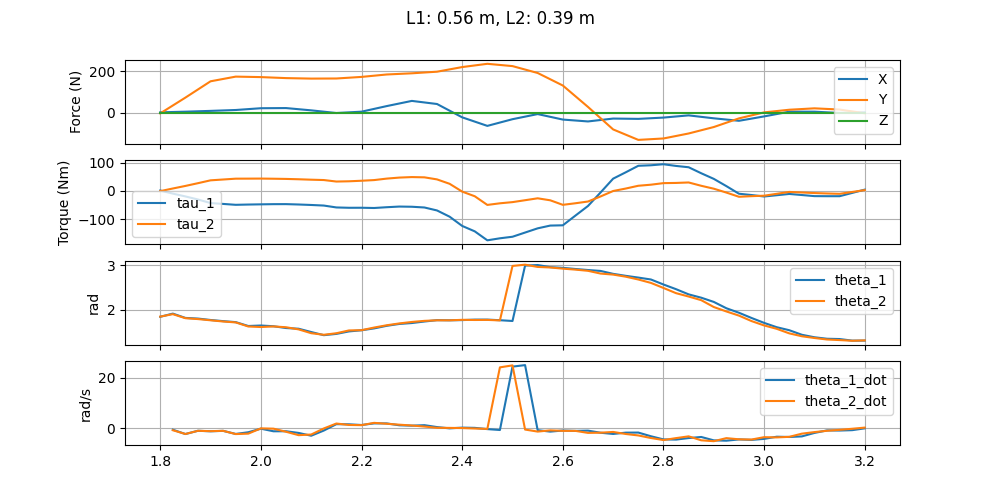

In [24]:
fig, axs = plt.subplots(4, 1, figsize=(10, 5), sharex=True)
fig.suptitle(f"L1: {float(l1):.2f} m, L2: {float(l2):.2f} m")
axs[0].plot(time_vector, assistive_force)
axs[0].set_ylabel("Force (N)")
axs[0].legend(["X", "Y", "Z"])
axs[0].grid()

axs[1].plot(time_vector, tau_1, label="tau_1")
axs[1].plot(time_vector, tau_2, label="tau_2")
axs[1].legend()
axs[1].set_ylabel("Torque (Nm)")
axs[1].grid()

axs[2].plot(time_vector, theta_1, label="theta_1")
axs[2].plot(time_vector, theta_2, label="theta_2")
axs[2].legend()
axs[2].set_ylabel("rad")
axs[2].grid()

axs[3].plot(time_vector, theta_1_dot, label="theta_1_dot")
axs[3].plot(time_vector, theta_2_dot, label="theta_2_dot")
axs[3].legend()
axs[3].set_ylabel("rad/s")
axs[3].grid()
